In [3]:
!pip install keras

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [5]:
#load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#preprocess data
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


11493376/11490434 [==============================] - 2s 0us/step


In [6]:
#compile CNN network for MNIST classification 
inputs = Input(shape=(28,28,1))
net = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
net = Conv2D(64, kernel_size=(3, 3),
                 activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation='softmax')(net)

mnist_model = Model(inputs=inputs, outputs=outputs, name='classification_model')
mnist_model.compile(optimizer='nadam', loss='categorical_crossentropy',metrics=[categorical_accuracy])


In [8]:
#train MNIST classifer
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

mnist_model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(x_test, y_test),
               callbacks=[earlyStop])

print(mnist_model.evaluate(x_train, y_train))
print(mnist_model.evaluate(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0814 - categorical_accuracy: 0.9762 - val_loss: 0.0457 - val_categorical_accuracy: 0.9853
Epoch 2/100
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0593 - categorical_accuracy: 0.9819 - val_loss: 0.0351 - val_categorical_accuracy: 0.9895
Epoch 3/100
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0502 - categorical_accuracy: 0.9843 - val_loss: 0.0319 - val_categorical_accuracy: 0.9903
Epoch 4/100
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0401 - categorical_accuracy: 0.9874 - val_loss: 0.0300 - val_categorical_accuracy: 0.9907
Epoch 5/100
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0356 - categorical_accuracy: 0.9886 - val_loss: 0.0311 - val_categorical_accuracy: 0.9903
Epoch 6/100
60000/60000 [==============================] - 94s 2ms/step - loss: 0.0327 - 

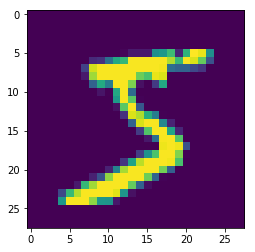

In [9]:
#select image to create an adversarial example from
img = x_train[0:1]
plt.imshow(img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()

In [10]:
#varify accurate classificaiton
prediction = mnist_model.predict(img)[0]
print(prediction)

[4.8761597e-23 4.1321918e-15 3.7236917e-24 1.1982729e-08 4.0585407e-19
 1.0000000e+00 9.1701121e-16 5.4166334e-18 2.6007878e-15 5.6234000e-11]


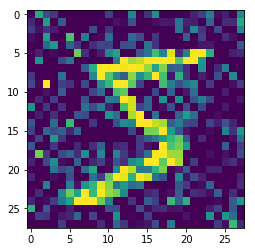

In [37]:
#applying random noise does not fool the classifier
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
noisy_img = np.clip(img + quantized_noise, 0., 1.)
plt.imshow(noisy_img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()

In [40]:
noisy_img.shape

(1, 28, 28, 1)

In [19]:
noisy_prediction = mnist_model.predict(noisy_img)[0]
print(noisy_prediction)

[2.0859692e-14 1.1804514e-08 1.3961542e-14 8.7334891e-04 3.9763670e-12
 9.9912661e-01 1.5866111e-09 2.8568476e-11 1.2821918e-08 1.7920534e-08]


In [20]:
#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})

In [44]:
#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(28,28,1),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='one')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(28*28,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((28,28,1),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='nadam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'one':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=10000,verbose=0,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((28,28)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((28,28)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    adversarial_prediction = mnist_model.predict(adversarial_img.reshape((1,28,28,1)))
    print(adversarial_prediction)
    
    return adversarial_img


Epoch 00001: loss improved from inf to 0.30110, saving model to ./adversarial_weights.h5

Epoch 00002: loss improved from 0.30110 to 0.28525, saving model to ./adversarial_weights.h5

Epoch 00003: loss improved from 0.28525 to 0.27353, saving model to ./adversarial_weights.h5

Epoch 00004: loss improved from 0.27353 to 0.26316, saving model to ./adversarial_weights.h5

Epoch 00005: loss improved from 0.26316 to 0.25280, saving model to ./adversarial_weights.h5

Epoch 00006: loss improved from 0.25280 to 0.24179, saving model to ./adversarial_weights.h5

Epoch 00007: loss improved from 0.24179 to 0.23250, saving model to ./adversarial_weights.h5

Epoch 00008: loss improved from 0.23250 to 0.22271, saving model to ./adversarial_weights.h5

Epoch 00009: loss improved from 0.22271 to 0.21254, saving model to ./adversarial_weights.h5

Epoch 00010: loss improved from 0.21254 to 0.20292, saving model to ./adversarial_weights.h5

Epoch 00011: loss improved from 0.20292 to 0.19326, saving mode


Epoch 00165: loss did not improve from -69.43271

Epoch 00166: loss improved from -69.43271 to -72.87702, saving model to ./adversarial_weights.h5

Epoch 00167: loss did not improve from -72.87702

Epoch 00168: loss did not improve from -72.87702

Epoch 00169: loss did not improve from -72.87702

Epoch 00170: loss improved from -72.87702 to -75.96013, saving model to ./adversarial_weights.h5

Epoch 00171: loss did not improve from -75.96013

Epoch 00172: loss improved from -75.96013 to -81.94180, saving model to ./adversarial_weights.h5

Epoch 00173: loss did not improve from -81.94180

Epoch 00174: loss did not improve from -81.94180

Epoch 00175: loss did not improve from -81.94180

Epoch 00176: loss did not improve from -81.94180

Epoch 00177: loss did not improve from -81.94180

Epoch 00178: loss did not improve from -81.94180

Epoch 00179: loss did not improve from -81.94180

Epoch 00180: loss did not improve from -81.94180

Epoch 00181: loss improved from -81.94180 to -95.48441,

Epoch 00317: loss did not improve from -189.96681

Epoch 00318: loss did not improve from -189.96681

Epoch 00319: loss did not improve from -189.96681

Epoch 00320: loss did not improve from -189.96681

Epoch 00321: loss did not improve from -189.96681

Epoch 00322: loss did not improve from -189.96681

Epoch 00323: loss did not improve from -189.96681

Epoch 00324: loss did not improve from -189.96681

Epoch 00325: loss did not improve from -189.96681

Epoch 00326: loss did not improve from -189.96681

Epoch 00327: loss did not improve from -189.96681

Epoch 00328: loss did not improve from -189.96681

Epoch 00329: loss did not improve from -189.96681

Epoch 00330: loss did not improve from -189.96681

Epoch 00331: loss did not improve from -189.96681

Epoch 00332: loss did not improve from -189.96681

Epoch 00333: loss did not improve from -189.96681

Epoch 00334: loss did not improve from -189.96681

Epoch 00335: loss did not improve from -189.96681

Epoch 00336: loss did not impro


Epoch 00499: loss did not improve from -292.50446

Epoch 00500: loss did not improve from -292.50446

Epoch 00501: loss did not improve from -292.50446

Epoch 00502: loss did not improve from -292.50446

Epoch 00503: loss did not improve from -292.50446

Epoch 00504: loss did not improve from -292.50446

Epoch 00505: loss did not improve from -292.50446

Epoch 00506: loss did not improve from -292.50446

Epoch 00507: loss did not improve from -292.50446

Epoch 00508: loss did not improve from -292.50446

Epoch 00509: loss did not improve from -292.50446

Epoch 00510: loss did not improve from -292.50446

Epoch 00511: loss did not improve from -292.50446

Epoch 00512: loss did not improve from -292.50446

Epoch 00513: loss did not improve from -292.50446

Epoch 00514: loss did not improve from -292.50446

Epoch 00515: loss did not improve from -292.50446

Epoch 00516: loss did not improve from -292.50446

Epoch 00517: loss did not improve from -292.50446

Epoch 00518: loss did not impr

Epoch 00676: loss did not improve from -332.25964

Epoch 00677: loss did not improve from -332.25964

Epoch 00678: loss did not improve from -332.25964

Epoch 00679: loss did not improve from -332.25964

Epoch 00680: loss did not improve from -332.25964

Epoch 00681: loss did not improve from -332.25964

Epoch 00682: loss did not improve from -332.25964

Epoch 00683: loss did not improve from -332.25964

Epoch 00684: loss did not improve from -332.25964

Epoch 00685: loss did not improve from -332.25964

Epoch 00686: loss did not improve from -332.25964

Epoch 00687: loss did not improve from -332.25964

Epoch 00688: loss did not improve from -332.25964

Epoch 00689: loss did not improve from -332.25964

Epoch 00690: loss did not improve from -332.25964

Epoch 00691: loss did not improve from -332.25964

Epoch 00692: loss did not improve from -332.25964

Epoch 00693: loss did not improve from -332.25964

Epoch 00694: loss did not improve from -332.25964

Epoch 00695: loss did not impro

Epoch 00864: loss did not improve from -343.76303

Epoch 00865: loss did not improve from -343.76303

Epoch 00866: loss did not improve from -343.76303

Epoch 00867: loss did not improve from -343.76303

Epoch 00868: loss did not improve from -343.76303

Epoch 00869: loss did not improve from -343.76303

Epoch 00870: loss did not improve from -343.76303

Epoch 00871: loss did not improve from -343.76303

Epoch 00872: loss did not improve from -343.76303

Epoch 00873: loss did not improve from -343.76303

Epoch 00874: loss did not improve from -343.76303

Epoch 00875: loss did not improve from -343.76303

Epoch 00876: loss did not improve from -343.76303

Epoch 00877: loss did not improve from -343.76303

Epoch 00878: loss did not improve from -343.76303

Epoch 00879: loss did not improve from -343.76303

Epoch 00880: loss did not improve from -343.76303

Epoch 00881: loss did not improve from -343.76303

Epoch 00882: loss did not improve from -343.76303

Epoch 00883: loss did not impro

Epoch 01046: loss did not improve from -361.15506

Epoch 01047: loss did not improve from -361.15506

Epoch 01048: loss did not improve from -361.15506

Epoch 01049: loss did not improve from -361.15506

Epoch 01050: loss did not improve from -361.15506

Epoch 01051: loss did not improve from -361.15506

Epoch 01052: loss did not improve from -361.15506

Epoch 01053: loss did not improve from -361.15506

Epoch 01054: loss did not improve from -361.15506

Epoch 01055: loss did not improve from -361.15506

Epoch 01056: loss did not improve from -361.15506

Epoch 01057: loss did not improve from -361.15506

Epoch 01058: loss did not improve from -361.15506

Epoch 01059: loss did not improve from -361.15506

Epoch 01060: loss did not improve from -361.15506

Epoch 01061: loss did not improve from -361.15506

Epoch 01062: loss did not improve from -361.15506

Epoch 01063: loss did not improve from -361.15506

Epoch 01064: loss did not improve from -361.15506

Epoch 01065: loss did not impro

Epoch 01237: loss did not improve from -361.15506

Epoch 01238: loss did not improve from -361.15506

Epoch 01239: loss did not improve from -361.15506

Epoch 01240: loss did not improve from -361.15506

Epoch 01241: loss did not improve from -361.15506

Epoch 01242: loss did not improve from -361.15506

Epoch 01243: loss did not improve from -361.15506

Epoch 01244: loss did not improve from -361.15506

Epoch 01245: loss did not improve from -361.15506

Epoch 01246: loss did not improve from -361.15506

Epoch 01247: loss did not improve from -361.15506

Epoch 01248: loss did not improve from -361.15506

Epoch 01249: loss did not improve from -361.15506

Epoch 01250: loss did not improve from -361.15506

Epoch 01251: loss did not improve from -361.15506

Epoch 01252: loss improved from -361.15506 to -371.06866, saving model to ./adversarial_weights.h5

Epoch 01253: loss did not improve from -371.06866

Epoch 01254: loss did not improve from -371.06866

Epoch 01255: loss did not improve


Epoch 01402: loss did not improve from -395.40924

Epoch 01403: loss did not improve from -395.40924

Epoch 01404: loss did not improve from -395.40924

Epoch 01405: loss did not improve from -395.40924

Epoch 01406: loss did not improve from -395.40924

Epoch 01407: loss did not improve from -395.40924

Epoch 01408: loss did not improve from -395.40924

Epoch 01409: loss did not improve from -395.40924

Epoch 01410: loss did not improve from -395.40924

Epoch 01411: loss did not improve from -395.40924

Epoch 01412: loss did not improve from -395.40924

Epoch 01413: loss did not improve from -395.40924

Epoch 01414: loss did not improve from -395.40924

Epoch 01415: loss did not improve from -395.40924

Epoch 01416: loss did not improve from -395.40924

Epoch 01417: loss did not improve from -395.40924

Epoch 01418: loss did not improve from -395.40924

Epoch 01419: loss did not improve from -395.40924

Epoch 01420: loss did not improve from -395.40924

Epoch 01421: loss did not impr

Epoch 01589: loss did not improve from -445.81558

Epoch 01590: loss did not improve from -445.81558

Epoch 01591: loss did not improve from -445.81558

Epoch 01592: loss did not improve from -445.81558

Epoch 01593: loss did not improve from -445.81558

Epoch 01594: loss did not improve from -445.81558

Epoch 01595: loss did not improve from -445.81558

Epoch 01596: loss did not improve from -445.81558

Epoch 01597: loss did not improve from -445.81558

Epoch 01598: loss did not improve from -445.81558

Epoch 01599: loss did not improve from -445.81558

Epoch 01600: loss did not improve from -445.81558

Epoch 01601: loss did not improve from -445.81558

Epoch 01602: loss did not improve from -445.81558

Epoch 01603: loss did not improve from -445.81558

Epoch 01604: loss did not improve from -445.81558

Epoch 01605: loss did not improve from -445.81558

Epoch 01606: loss did not improve from -445.81558

Epoch 01607: loss did not improve from -445.81558

Epoch 01608: loss did not impro

Epoch 01778: loss did not improve from -445.81558

Epoch 01779: loss did not improve from -445.81558

Epoch 01780: loss did not improve from -445.81558

Epoch 01781: loss did not improve from -445.81558

Epoch 01782: loss did not improve from -445.81558

Epoch 01783: loss did not improve from -445.81558

Epoch 01784: loss did not improve from -445.81558

Epoch 01785: loss did not improve from -445.81558

Epoch 01786: loss did not improve from -445.81558

Epoch 01787: loss did not improve from -445.81558

Epoch 01788: loss did not improve from -445.81558

Epoch 01789: loss did not improve from -445.81558

Epoch 01790: loss did not improve from -445.81558

Epoch 01791: loss did not improve from -445.81558

Epoch 01792: loss did not improve from -445.81558

Epoch 01793: loss did not improve from -445.81558

Epoch 01794: loss did not improve from -445.81558

Epoch 01795: loss did not improve from -445.81558

Epoch 01796: loss did not improve from -445.81558

Epoch 01797: loss did not impro

Epoch 01960: loss did not improve from -447.95087

Epoch 01961: loss did not improve from -447.95087

Epoch 01962: loss did not improve from -447.95087

Epoch 01963: loss did not improve from -447.95087

Epoch 01964: loss did not improve from -447.95087

Epoch 01965: loss did not improve from -447.95087

Epoch 01966: loss did not improve from -447.95087

Epoch 01967: loss did not improve from -447.95087

Epoch 01968: loss did not improve from -447.95087

Epoch 01969: loss did not improve from -447.95087

Epoch 01970: loss did not improve from -447.95087

Epoch 01971: loss did not improve from -447.95087

Epoch 01972: loss did not improve from -447.95087

Epoch 01973: loss did not improve from -447.95087

Epoch 01974: loss did not improve from -447.95087

Epoch 01975: loss did not improve from -447.95087

Epoch 01976: loss did not improve from -447.95087

Epoch 01977: loss did not improve from -447.95087

Epoch 01978: loss did not improve from -447.95087

Epoch 01979: loss did not impro

Epoch 02133: loss did not improve from -473.39444

Epoch 02134: loss did not improve from -473.39444

Epoch 02135: loss did not improve from -473.39444

Epoch 02136: loss did not improve from -473.39444

Epoch 02137: loss did not improve from -473.39444

Epoch 02138: loss did not improve from -473.39444

Epoch 02139: loss did not improve from -473.39444

Epoch 02140: loss did not improve from -473.39444

Epoch 02141: loss did not improve from -473.39444

Epoch 02142: loss did not improve from -473.39444

Epoch 02143: loss did not improve from -473.39444

Epoch 02144: loss did not improve from -473.39444

Epoch 02145: loss did not improve from -473.39444

Epoch 02146: loss did not improve from -473.39444

Epoch 02147: loss did not improve from -473.39444

Epoch 02148: loss did not improve from -473.39444

Epoch 02149: loss did not improve from -473.39444

Epoch 02150: loss did not improve from -473.39444

Epoch 02151: loss did not improve from -473.39444

Epoch 02152: loss did not impro


Epoch 02318: loss did not improve from -479.84763

Epoch 02319: loss did not improve from -479.84763

Epoch 02320: loss did not improve from -479.84763

Epoch 02321: loss did not improve from -479.84763

Epoch 02322: loss did not improve from -479.84763

Epoch 02323: loss did not improve from -479.84763

Epoch 02324: loss did not improve from -479.84763

Epoch 02325: loss did not improve from -479.84763

Epoch 02326: loss did not improve from -479.84763

Epoch 02327: loss did not improve from -479.84763

Epoch 02328: loss did not improve from -479.84763

Epoch 02329: loss did not improve from -479.84763

Epoch 02330: loss did not improve from -479.84763

Epoch 02331: loss did not improve from -479.84763

Epoch 02332: loss did not improve from -479.84763

Epoch 02333: loss did not improve from -479.84763

Epoch 02334: loss did not improve from -479.84763

Epoch 02335: loss did not improve from -479.84763

Epoch 02336: loss did not improve from -479.84763

Epoch 02337: loss did not impr

Epoch 02510: loss did not improve from -479.84763

Epoch 02511: loss did not improve from -479.84763

Epoch 02512: loss did not improve from -479.84763

Epoch 02513: loss did not improve from -479.84763

Epoch 02514: loss did not improve from -479.84763

Epoch 02515: loss did not improve from -479.84763

Epoch 02516: loss did not improve from -479.84763

Epoch 02517: loss did not improve from -479.84763

Epoch 02518: loss did not improve from -479.84763

Epoch 02519: loss did not improve from -479.84763

Epoch 02520: loss did not improve from -479.84763

Epoch 02521: loss did not improve from -479.84763

Epoch 02522: loss did not improve from -479.84763

Epoch 02523: loss did not improve from -479.84763

Epoch 02524: loss did not improve from -479.84763

Epoch 02525: loss did not improve from -479.84763

Epoch 02526: loss did not improve from -479.84763

Epoch 02527: loss did not improve from -479.84763

Epoch 02528: loss did not improve from -479.84763

Epoch 02529: loss did not impro

Epoch 02672: loss did not improve from -479.84763

Epoch 02673: loss did not improve from -479.84763

Epoch 02674: loss did not improve from -479.84763

Epoch 02675: loss did not improve from -479.84763

Epoch 02676: loss did not improve from -479.84763

Epoch 02677: loss did not improve from -479.84763

Epoch 02678: loss did not improve from -479.84763

Epoch 02679: loss did not improve from -479.84763

Epoch 02680: loss did not improve from -479.84763

Epoch 02681: loss did not improve from -479.84763

Epoch 02682: loss did not improve from -479.84763

Epoch 02683: loss did not improve from -479.84763

Epoch 02684: loss did not improve from -479.84763

Epoch 02685: loss did not improve from -479.84763

Epoch 02686: loss did not improve from -479.84763

Epoch 02687: loss did not improve from -479.84763

Epoch 02688: loss did not improve from -479.84763

Epoch 02689: loss did not improve from -479.84763

Epoch 02690: loss did not improve from -479.84763

Epoch 02691: loss did not impro


Epoch 02836: loss did not improve from -479.84763

Epoch 02837: loss did not improve from -479.84763

Epoch 02838: loss did not improve from -479.84763

Epoch 02839: loss did not improve from -479.84763

Epoch 02840: loss did not improve from -479.84763

Epoch 02841: loss did not improve from -479.84763

Epoch 02842: loss did not improve from -479.84763

Epoch 02843: loss did not improve from -479.84763

Epoch 02844: loss did not improve from -479.84763

Epoch 02845: loss did not improve from -479.84763

Epoch 02846: loss did not improve from -479.84763

Epoch 02847: loss did not improve from -479.84763

Epoch 02848: loss did not improve from -479.84763

Epoch 02849: loss did not improve from -479.84763

Epoch 02850: loss did not improve from -479.84763

Epoch 02851: loss did not improve from -479.84763

Epoch 02852: loss did not improve from -479.84763

Epoch 02853: loss did not improve from -479.84763

Epoch 02854: loss did not improve from -479.84763

Epoch 02855: loss did not impr

Epoch 02996: loss did not improve from -479.84763

Epoch 02997: loss did not improve from -479.84763

Epoch 02998: loss did not improve from -479.84763

Epoch 02999: loss did not improve from -479.84763

Epoch 03000: loss did not improve from -479.84763

Epoch 03001: loss did not improve from -479.84763

Epoch 03002: loss did not improve from -479.84763

Epoch 03003: loss did not improve from -479.84763

Epoch 03004: loss did not improve from -479.84763

Epoch 03005: loss did not improve from -479.84763

Epoch 03006: loss did not improve from -479.84763

Epoch 03007: loss did not improve from -479.84763

Epoch 03008: loss did not improve from -479.84763

Epoch 03009: loss did not improve from -479.84763

Epoch 03010: loss did not improve from -479.84763

Epoch 03011: loss did not improve from -479.84763

Epoch 03012: loss did not improve from -479.84763

Epoch 03013: loss did not improve from -479.84763

Epoch 03014: loss did not improve from -479.84763

Epoch 03015: loss did not impro

Epoch 03156: loss did not improve from -479.84763

Epoch 03157: loss did not improve from -479.84763

Epoch 03158: loss did not improve from -479.84763

Epoch 03159: loss did not improve from -479.84763

Epoch 03160: loss did not improve from -479.84763

Epoch 03161: loss did not improve from -479.84763

Epoch 03162: loss did not improve from -479.84763

Epoch 03163: loss did not improve from -479.84763

Epoch 03164: loss did not improve from -479.84763

Epoch 03165: loss did not improve from -479.84763

Epoch 03166: loss did not improve from -479.84763

Epoch 03167: loss did not improve from -479.84763

Epoch 03168: loss did not improve from -479.84763

Epoch 03169: loss did not improve from -479.84763

Epoch 03170: loss did not improve from -479.84763

Epoch 03171: loss did not improve from -479.84763

Epoch 03172: loss did not improve from -479.84763

Epoch 03173: loss did not improve from -479.84763

Epoch 03174: loss did not improve from -479.84763

Epoch 03175: loss did not impro


Epoch 03348: loss did not improve from -479.84763

Epoch 03349: loss did not improve from -479.84763

Epoch 03350: loss did not improve from -479.84763

Epoch 03351: loss did not improve from -479.84763

Epoch 03352: loss did not improve from -479.84763

Epoch 03353: loss did not improve from -479.84763

Epoch 03354: loss did not improve from -479.84763

Epoch 03355: loss did not improve from -479.84763

Epoch 03356: loss did not improve from -479.84763

Epoch 03357: loss did not improve from -479.84763

Epoch 03358: loss did not improve from -479.84763

Epoch 03359: loss did not improve from -479.84763

Epoch 03360: loss did not improve from -479.84763

Epoch 03361: loss did not improve from -479.84763

Epoch 03362: loss did not improve from -479.84763

Epoch 03363: loss did not improve from -479.84763

Epoch 03364: loss did not improve from -479.84763

Epoch 03365: loss did not improve from -479.84763

Epoch 03366: loss did not improve from -479.84763

Epoch 03367: loss did not impr

Epoch 03508: loss did not improve from -481.76151

Epoch 03509: loss did not improve from -481.76151

Epoch 03510: loss did not improve from -481.76151

Epoch 03511: loss did not improve from -481.76151

Epoch 03512: loss did not improve from -481.76151

Epoch 03513: loss did not improve from -481.76151

Epoch 03514: loss did not improve from -481.76151

Epoch 03515: loss did not improve from -481.76151

Epoch 03516: loss did not improve from -481.76151

Epoch 03517: loss did not improve from -481.76151

Epoch 03518: loss did not improve from -481.76151

Epoch 03519: loss did not improve from -481.76151

Epoch 03520: loss did not improve from -481.76151

Epoch 03521: loss did not improve from -481.76151

Epoch 03522: loss did not improve from -481.76151

Epoch 03523: loss did not improve from -481.76151

Epoch 03524: loss did not improve from -481.76151

Epoch 03525: loss did not improve from -481.76151

Epoch 03526: loss did not improve from -481.76151

Epoch 03527: loss did not impro


Epoch 03697: loss did not improve from -518.66034

Epoch 03698: loss did not improve from -518.66034

Epoch 03699: loss did not improve from -518.66034

Epoch 03700: loss did not improve from -518.66034

Epoch 03701: loss did not improve from -518.66034

Epoch 03702: loss did not improve from -518.66034

Epoch 03703: loss did not improve from -518.66034

Epoch 03704: loss did not improve from -518.66034

Epoch 03705: loss did not improve from -518.66034

Epoch 03706: loss did not improve from -518.66034

Epoch 03707: loss did not improve from -518.66034

Epoch 03708: loss did not improve from -518.66034

Epoch 03709: loss did not improve from -518.66034

Epoch 03710: loss did not improve from -518.66034

Epoch 03711: loss did not improve from -518.66034

Epoch 03712: loss did not improve from -518.66034

Epoch 03713: loss did not improve from -518.66034

Epoch 03714: loss did not improve from -518.66034

Epoch 03715: loss did not improve from -518.66034

Epoch 03716: loss did not impr


Epoch 03884: loss did not improve from -621.73712

Epoch 03885: loss did not improve from -621.73712

Epoch 03886: loss did not improve from -621.73712

Epoch 03887: loss did not improve from -621.73712

Epoch 03888: loss did not improve from -621.73712

Epoch 03889: loss did not improve from -621.73712

Epoch 03890: loss did not improve from -621.73712

Epoch 03891: loss did not improve from -621.73712

Epoch 03892: loss did not improve from -621.73712

Epoch 03893: loss did not improve from -621.73712

Epoch 03894: loss did not improve from -621.73712

Epoch 03895: loss did not improve from -621.73712

Epoch 03896: loss did not improve from -621.73712

Epoch 03897: loss did not improve from -621.73712

Epoch 03898: loss did not improve from -621.73712

Epoch 03899: loss did not improve from -621.73712

Epoch 03900: loss did not improve from -621.73712

Epoch 03901: loss did not improve from -621.73712

Epoch 03902: loss did not improve from -621.73712

Epoch 03903: loss did not impr

Epoch 04044: loss did not improve from -621.73712

Epoch 04045: loss did not improve from -621.73712

Epoch 04046: loss did not improve from -621.73712

Epoch 04047: loss did not improve from -621.73712

Epoch 04048: loss did not improve from -621.73712

Epoch 04049: loss did not improve from -621.73712

Epoch 04050: loss did not improve from -621.73712

Epoch 04051: loss did not improve from -621.73712

Epoch 04052: loss did not improve from -621.73712

Epoch 04053: loss did not improve from -621.73712

Epoch 04054: loss did not improve from -621.73712

Epoch 04055: loss did not improve from -621.73712

Epoch 04056: loss did not improve from -621.73712

Epoch 04057: loss did not improve from -621.73712

Epoch 04058: loss did not improve from -621.73712

Epoch 04059: loss did not improve from -621.73712

Epoch 04060: loss did not improve from -621.73712

Epoch 04061: loss did not improve from -621.73712

Epoch 04062: loss did not improve from -621.73712

Epoch 04063: loss did not impro


Epoch 04234: loss did not improve from -621.73712

Epoch 04235: loss did not improve from -621.73712

Epoch 04236: loss did not improve from -621.73712

Epoch 04237: loss did not improve from -621.73712

Epoch 04238: loss did not improve from -621.73712

Epoch 04239: loss did not improve from -621.73712

Epoch 04240: loss did not improve from -621.73712

Epoch 04241: loss did not improve from -621.73712

Epoch 04242: loss did not improve from -621.73712

Epoch 04243: loss did not improve from -621.73712

Epoch 04244: loss did not improve from -621.73712

Epoch 04245: loss did not improve from -621.73712

Epoch 04246: loss did not improve from -621.73712

Epoch 04247: loss did not improve from -621.73712

Epoch 04248: loss did not improve from -621.73712

Epoch 04249: loss did not improve from -621.73712

Epoch 04250: loss did not improve from -621.73712

Epoch 04251: loss did not improve from -621.73712

Epoch 04252: loss did not improve from -621.73712

Epoch 04253: loss did not impr

Epoch 04418: loss did not improve from -621.73712

Epoch 04419: loss did not improve from -621.73712

Epoch 04420: loss did not improve from -621.73712

Epoch 04421: loss did not improve from -621.73712

Epoch 04422: loss did not improve from -621.73712

Epoch 04423: loss did not improve from -621.73712

Epoch 04424: loss did not improve from -621.73712

Epoch 04425: loss did not improve from -621.73712

Epoch 04426: loss did not improve from -621.73712

Epoch 04427: loss did not improve from -621.73712

Epoch 04428: loss did not improve from -621.73712

Epoch 04429: loss did not improve from -621.73712

Epoch 04430: loss did not improve from -621.73712

Epoch 04431: loss did not improve from -621.73712

Epoch 04432: loss did not improve from -621.73712

Epoch 04433: loss did not improve from -621.73712

Epoch 04434: loss did not improve from -621.73712

Epoch 04435: loss did not improve from -621.73712

Epoch 04436: loss did not improve from -621.73712

Epoch 04437: loss did not impro


Epoch 04604: loss did not improve from -638.58954

Epoch 04605: loss did not improve from -638.58954

Epoch 04606: loss did not improve from -638.58954

Epoch 04607: loss did not improve from -638.58954

Epoch 04608: loss did not improve from -638.58954

Epoch 04609: loss did not improve from -638.58954

Epoch 04610: loss did not improve from -638.58954

Epoch 04611: loss did not improve from -638.58954

Epoch 04612: loss did not improve from -638.58954

Epoch 04613: loss did not improve from -638.58954

Epoch 04614: loss did not improve from -638.58954

Epoch 04615: loss did not improve from -638.58954

Epoch 04616: loss did not improve from -638.58954

Epoch 04617: loss did not improve from -638.58954

Epoch 04618: loss did not improve from -638.58954

Epoch 04619: loss did not improve from -638.58954

Epoch 04620: loss did not improve from -638.58954

Epoch 04621: loss did not improve from -638.58954

Epoch 04622: loss did not improve from -638.58954

Epoch 04623: loss did not impr


Epoch 04789: loss did not improve from -647.77173

Epoch 04790: loss did not improve from -647.77173

Epoch 04791: loss did not improve from -647.77173

Epoch 04792: loss did not improve from -647.77173

Epoch 04793: loss did not improve from -647.77173

Epoch 04794: loss did not improve from -647.77173

Epoch 04795: loss did not improve from -647.77173

Epoch 04796: loss did not improve from -647.77173

Epoch 04797: loss did not improve from -647.77173

Epoch 04798: loss did not improve from -647.77173

Epoch 04799: loss did not improve from -647.77173

Epoch 04800: loss did not improve from -647.77173

Epoch 04801: loss did not improve from -647.77173

Epoch 04802: loss did not improve from -647.77173

Epoch 04803: loss did not improve from -647.77173

Epoch 04804: loss did not improve from -647.77173

Epoch 04805: loss did not improve from -647.77173

Epoch 04806: loss did not improve from -647.77173

Epoch 04807: loss did not improve from -647.77173

Epoch 04808: loss did not impr


Epoch 04981: loss did not improve from -647.77173

Epoch 04982: loss did not improve from -647.77173

Epoch 04983: loss did not improve from -647.77173

Epoch 04984: loss did not improve from -647.77173

Epoch 04985: loss did not improve from -647.77173

Epoch 04986: loss did not improve from -647.77173

Epoch 04987: loss did not improve from -647.77173

Epoch 04988: loss did not improve from -647.77173

Epoch 04989: loss did not improve from -647.77173

Epoch 04990: loss did not improve from -647.77173

Epoch 04991: loss did not improve from -647.77173

Epoch 04992: loss did not improve from -647.77173

Epoch 04993: loss did not improve from -647.77173

Epoch 04994: loss did not improve from -647.77173

Epoch 04995: loss did not improve from -647.77173

Epoch 04996: loss did not improve from -647.77173

Epoch 04997: loss did not improve from -647.77173

Epoch 04998: loss did not improve from -647.77173

Epoch 04999: loss did not improve from -647.77173

Epoch 05000: loss did not impr


Epoch 05141: loss did not improve from -704.49982

Epoch 05142: loss did not improve from -704.49982

Epoch 05143: loss did not improve from -704.49982

Epoch 05144: loss did not improve from -704.49982

Epoch 05145: loss did not improve from -704.49982

Epoch 05146: loss did not improve from -704.49982

Epoch 05147: loss did not improve from -704.49982

Epoch 05148: loss did not improve from -704.49982

Epoch 05149: loss did not improve from -704.49982

Epoch 05150: loss did not improve from -704.49982

Epoch 05151: loss did not improve from -704.49982

Epoch 05152: loss did not improve from -704.49982

Epoch 05153: loss did not improve from -704.49982

Epoch 05154: loss did not improve from -704.49982

Epoch 05155: loss did not improve from -704.49982

Epoch 05156: loss did not improve from -704.49982

Epoch 05157: loss did not improve from -704.49982

Epoch 05158: loss did not improve from -704.49982

Epoch 05159: loss did not improve from -704.49982

Epoch 05160: loss did not impr

Epoch 05304: loss did not improve from -704.49982

Epoch 05305: loss did not improve from -704.49982

Epoch 05306: loss did not improve from -704.49982

Epoch 05307: loss did not improve from -704.49982

Epoch 05308: loss did not improve from -704.49982

Epoch 05309: loss did not improve from -704.49982

Epoch 05310: loss did not improve from -704.49982

Epoch 05311: loss did not improve from -704.49982

Epoch 05312: loss did not improve from -704.49982

Epoch 05313: loss did not improve from -704.49982

Epoch 05314: loss did not improve from -704.49982

Epoch 05315: loss did not improve from -704.49982

Epoch 05316: loss did not improve from -704.49982

Epoch 05317: loss did not improve from -704.49982

Epoch 05318: loss did not improve from -704.49982

Epoch 05319: loss did not improve from -704.49982

Epoch 05320: loss did not improve from -704.49982

Epoch 05321: loss did not improve from -704.49982

Epoch 05322: loss did not improve from -704.49982

Epoch 05323: loss did not impro

Epoch 05492: loss did not improve from -704.49982

Epoch 05493: loss did not improve from -704.49982

Epoch 05494: loss did not improve from -704.49982

Epoch 05495: loss did not improve from -704.49982

Epoch 05496: loss did not improve from -704.49982

Epoch 05497: loss did not improve from -704.49982

Epoch 05498: loss did not improve from -704.49982

Epoch 05499: loss did not improve from -704.49982

Epoch 05500: loss did not improve from -704.49982

Epoch 05501: loss did not improve from -704.49982

Epoch 05502: loss did not improve from -704.49982

Epoch 05503: loss did not improve from -704.49982

Epoch 05504: loss did not improve from -704.49982

Epoch 05505: loss did not improve from -704.49982

Epoch 05506: loss did not improve from -704.49982

Epoch 05507: loss did not improve from -704.49982

Epoch 05508: loss did not improve from -704.49982

Epoch 05509: loss did not improve from -704.49982

Epoch 05510: loss did not improve from -704.49982

Epoch 05511: loss did not impro

Epoch 05654: loss did not improve from -704.49982

Epoch 05655: loss did not improve from -704.49982

Epoch 05656: loss did not improve from -704.49982

Epoch 05657: loss did not improve from -704.49982

Epoch 05658: loss did not improve from -704.49982

Epoch 05659: loss did not improve from -704.49982

Epoch 05660: loss did not improve from -704.49982

Epoch 05661: loss did not improve from -704.49982

Epoch 05662: loss did not improve from -704.49982

Epoch 05663: loss did not improve from -704.49982

Epoch 05664: loss did not improve from -704.49982

Epoch 05665: loss did not improve from -704.49982

Epoch 05666: loss did not improve from -704.49982

Epoch 05667: loss did not improve from -704.49982

Epoch 05668: loss did not improve from -704.49982

Epoch 05669: loss did not improve from -704.49982

Epoch 05670: loss did not improve from -704.49982

Epoch 05671: loss did not improve from -704.49982

Epoch 05672: loss did not improve from -704.49982

Epoch 05673: loss did not impro


Epoch 05820: loss did not improve from -704.49982

Epoch 05821: loss did not improve from -704.49982

Epoch 05822: loss did not improve from -704.49982

Epoch 05823: loss did not improve from -704.49982

Epoch 05824: loss did not improve from -704.49982

Epoch 05825: loss did not improve from -704.49982

Epoch 05826: loss did not improve from -704.49982

Epoch 05827: loss did not improve from -704.49982

Epoch 05828: loss did not improve from -704.49982

Epoch 05829: loss did not improve from -704.49982

Epoch 05830: loss did not improve from -704.49982

Epoch 05831: loss did not improve from -704.49982

Epoch 05832: loss did not improve from -704.49982

Epoch 05833: loss did not improve from -704.49982

Epoch 05834: loss did not improve from -704.49982

Epoch 05835: loss did not improve from -704.49982

Epoch 05836: loss did not improve from -704.49982

Epoch 05837: loss did not improve from -704.49982

Epoch 05838: loss did not improve from -704.49982

Epoch 05839: loss did not impr


Epoch 05983: loss did not improve from -704.49982

Epoch 05984: loss did not improve from -704.49982

Epoch 05985: loss did not improve from -704.49982

Epoch 05986: loss did not improve from -704.49982

Epoch 05987: loss did not improve from -704.49982

Epoch 05988: loss did not improve from -704.49982

Epoch 05989: loss did not improve from -704.49982

Epoch 05990: loss did not improve from -704.49982

Epoch 05991: loss did not improve from -704.49982

Epoch 05992: loss did not improve from -704.49982

Epoch 05993: loss did not improve from -704.49982

Epoch 05994: loss did not improve from -704.49982

Epoch 05995: loss did not improve from -704.49982

Epoch 05996: loss did not improve from -704.49982

Epoch 05997: loss did not improve from -704.49982

Epoch 05998: loss did not improve from -704.49982

Epoch 05999: loss did not improve from -704.49982

Epoch 06000: loss did not improve from -704.49982

Epoch 06001: loss did not improve from -704.49982

Epoch 06002: loss did not impr


Epoch 06145: loss did not improve from -704.49982

Epoch 06146: loss did not improve from -704.49982

Epoch 06147: loss did not improve from -704.49982

Epoch 06148: loss did not improve from -704.49982

Epoch 06149: loss did not improve from -704.49982

Epoch 06150: loss did not improve from -704.49982

Epoch 06151: loss did not improve from -704.49982

Epoch 06152: loss did not improve from -704.49982

Epoch 06153: loss did not improve from -704.49982

Epoch 06154: loss did not improve from -704.49982

Epoch 06155: loss did not improve from -704.49982

Epoch 06156: loss did not improve from -704.49982

Epoch 06157: loss did not improve from -704.49982

Epoch 06158: loss did not improve from -704.49982

Epoch 06159: loss did not improve from -704.49982

Epoch 06160: loss did not improve from -704.49982

Epoch 06161: loss did not improve from -704.49982

Epoch 06162: loss did not improve from -704.49982

Epoch 06163: loss did not improve from -704.49982

Epoch 06164: loss did not impr


Epoch 06336: loss did not improve from -704.49982

Epoch 06337: loss did not improve from -704.49982

Epoch 06338: loss did not improve from -704.49982

Epoch 06339: loss did not improve from -704.49982

Epoch 06340: loss did not improve from -704.49982

Epoch 06341: loss did not improve from -704.49982

Epoch 06342: loss did not improve from -704.49982

Epoch 06343: loss did not improve from -704.49982

Epoch 06344: loss did not improve from -704.49982

Epoch 06345: loss did not improve from -704.49982

Epoch 06346: loss did not improve from -704.49982

Epoch 06347: loss did not improve from -704.49982

Epoch 06348: loss did not improve from -704.49982

Epoch 06349: loss did not improve from -704.49982

Epoch 06350: loss did not improve from -704.49982

Epoch 06351: loss did not improve from -704.49982

Epoch 06352: loss did not improve from -704.49982

Epoch 06353: loss did not improve from -704.49982

Epoch 06354: loss did not improve from -704.49982

Epoch 06355: loss did not impr

Epoch 06497: loss did not improve from -704.49982

Epoch 06498: loss did not improve from -704.49982

Epoch 06499: loss did not improve from -704.49982

Epoch 06500: loss did not improve from -704.49982

Epoch 06501: loss did not improve from -704.49982

Epoch 06502: loss did not improve from -704.49982

Epoch 06503: loss did not improve from -704.49982

Epoch 06504: loss did not improve from -704.49982

Epoch 06505: loss did not improve from -704.49982

Epoch 06506: loss did not improve from -704.49982

Epoch 06507: loss did not improve from -704.49982

Epoch 06508: loss did not improve from -704.49982

Epoch 06509: loss did not improve from -704.49982

Epoch 06510: loss did not improve from -704.49982

Epoch 06511: loss did not improve from -704.49982

Epoch 06512: loss did not improve from -704.49982

Epoch 06513: loss did not improve from -704.49982

Epoch 06514: loss did not improve from -704.49982

Epoch 06515: loss did not improve from -704.49982

Epoch 06516: loss did not impro


Epoch 06663: loss did not improve from -704.49982

Epoch 06664: loss did not improve from -704.49982

Epoch 06665: loss did not improve from -704.49982

Epoch 06666: loss did not improve from -704.49982

Epoch 06667: loss did not improve from -704.49982

Epoch 06668: loss did not improve from -704.49982

Epoch 06669: loss did not improve from -704.49982

Epoch 06670: loss did not improve from -704.49982

Epoch 06671: loss did not improve from -704.49982

Epoch 06672: loss did not improve from -704.49982

Epoch 06673: loss did not improve from -704.49982

Epoch 06674: loss did not improve from -704.49982

Epoch 06675: loss did not improve from -704.49982

Epoch 06676: loss did not improve from -704.49982

Epoch 06677: loss did not improve from -704.49982

Epoch 06678: loss did not improve from -704.49982

Epoch 06679: loss did not improve from -704.49982

Epoch 06680: loss did not improve from -704.49982

Epoch 06681: loss did not improve from -704.49982

Epoch 06682: loss did not impr


Epoch 06851: loss did not improve from -704.49982

Epoch 06852: loss did not improve from -704.49982

Epoch 06853: loss did not improve from -704.49982

Epoch 06854: loss did not improve from -704.49982

Epoch 06855: loss did not improve from -704.49982

Epoch 06856: loss did not improve from -704.49982

Epoch 06857: loss did not improve from -704.49982

Epoch 06858: loss did not improve from -704.49982

Epoch 06859: loss did not improve from -704.49982

Epoch 06860: loss did not improve from -704.49982

Epoch 06861: loss did not improve from -704.49982

Epoch 06862: loss did not improve from -704.49982

Epoch 06863: loss did not improve from -704.49982

Epoch 06864: loss did not improve from -704.49982

Epoch 06865: loss did not improve from -704.49982

Epoch 06866: loss did not improve from -704.49982

Epoch 06867: loss did not improve from -704.49982

Epoch 06868: loss did not improve from -704.49982

Epoch 06869: loss did not improve from -704.49982

Epoch 06870: loss did not impr


Epoch 07030: loss did not improve from -704.49982

Epoch 07031: loss did not improve from -704.49982

Epoch 07032: loss did not improve from -704.49982

Epoch 07033: loss did not improve from -704.49982

Epoch 07034: loss did not improve from -704.49982

Epoch 07035: loss did not improve from -704.49982

Epoch 07036: loss did not improve from -704.49982

Epoch 07037: loss did not improve from -704.49982

Epoch 07038: loss did not improve from -704.49982

Epoch 07039: loss did not improve from -704.49982

Epoch 07040: loss did not improve from -704.49982

Epoch 07041: loss did not improve from -704.49982

Epoch 07042: loss did not improve from -704.49982

Epoch 07043: loss did not improve from -704.49982

Epoch 07044: loss did not improve from -704.49982

Epoch 07045: loss did not improve from -704.49982

Epoch 07046: loss did not improve from -704.49982

Epoch 07047: loss did not improve from -704.49982

Epoch 07048: loss did not improve from -704.49982

Epoch 07049: loss did not impr

Epoch 07191: loss did not improve from -704.49982

Epoch 07192: loss did not improve from -704.49982

Epoch 07193: loss did not improve from -704.49982

Epoch 07194: loss did not improve from -704.49982

Epoch 07195: loss did not improve from -704.49982

Epoch 07196: loss did not improve from -704.49982

Epoch 07197: loss did not improve from -704.49982

Epoch 07198: loss did not improve from -704.49982

Epoch 07199: loss did not improve from -704.49982

Epoch 07200: loss did not improve from -704.49982

Epoch 07201: loss did not improve from -704.49982

Epoch 07202: loss did not improve from -704.49982

Epoch 07203: loss did not improve from -704.49982

Epoch 07204: loss did not improve from -704.49982

Epoch 07205: loss did not improve from -704.49982

Epoch 07206: loss did not improve from -704.49982

Epoch 07207: loss did not improve from -704.49982

Epoch 07208: loss did not improve from -704.49982

Epoch 07209: loss did not improve from -704.49982

Epoch 07210: loss did not impro

Epoch 07375: loss did not improve from -704.49982

Epoch 07376: loss did not improve from -704.49982

Epoch 07377: loss did not improve from -704.49982

Epoch 07378: loss did not improve from -704.49982

Epoch 07379: loss did not improve from -704.49982

Epoch 07380: loss did not improve from -704.49982

Epoch 07381: loss did not improve from -704.49982

Epoch 07382: loss did not improve from -704.49982

Epoch 07383: loss did not improve from -704.49982

Epoch 07384: loss did not improve from -704.49982

Epoch 07385: loss did not improve from -704.49982

Epoch 07386: loss did not improve from -704.49982

Epoch 07387: loss did not improve from -704.49982

Epoch 07388: loss did not improve from -704.49982

Epoch 07389: loss did not improve from -704.49982

Epoch 07390: loss did not improve from -704.49982

Epoch 07391: loss did not improve from -704.49982

Epoch 07392: loss did not improve from -704.49982

Epoch 07393: loss did not improve from -704.49982

Epoch 07394: loss did not impro


Epoch 07549: loss did not improve from -716.83972

Epoch 07550: loss did not improve from -716.83972

Epoch 07551: loss did not improve from -716.83972

Epoch 07552: loss did not improve from -716.83972

Epoch 07553: loss did not improve from -716.83972

Epoch 07554: loss did not improve from -716.83972

Epoch 07555: loss did not improve from -716.83972

Epoch 07556: loss did not improve from -716.83972

Epoch 07557: loss did not improve from -716.83972

Epoch 07558: loss did not improve from -716.83972

Epoch 07559: loss did not improve from -716.83972

Epoch 07560: loss did not improve from -716.83972

Epoch 07561: loss improved from -716.83972 to -741.99463, saving model to ./adversarial_weights.h5

Epoch 07562: loss did not improve from -741.99463

Epoch 07563: loss did not improve from -741.99463

Epoch 07564: loss did not improve from -741.99463

Epoch 07565: loss did not improve from -741.99463

Epoch 07566: loss did not improve from -741.99463

Epoch 07567: loss did not improv


Epoch 07722: loss did not improve from -760.17273

Epoch 07723: loss did not improve from -760.17273

Epoch 07724: loss did not improve from -760.17273

Epoch 07725: loss did not improve from -760.17273

Epoch 07726: loss did not improve from -760.17273

Epoch 07727: loss did not improve from -760.17273

Epoch 07728: loss did not improve from -760.17273

Epoch 07729: loss did not improve from -760.17273

Epoch 07730: loss did not improve from -760.17273

Epoch 07731: loss did not improve from -760.17273

Epoch 07732: loss did not improve from -760.17273

Epoch 07733: loss did not improve from -760.17273

Epoch 07734: loss did not improve from -760.17273

Epoch 07735: loss did not improve from -760.17273

Epoch 07736: loss did not improve from -760.17273

Epoch 07737: loss did not improve from -760.17273

Epoch 07738: loss did not improve from -760.17273

Epoch 07739: loss did not improve from -760.17273

Epoch 07740: loss did not improve from -760.17273

Epoch 07741: loss did not impr


Epoch 07883: loss did not improve from -760.17273

Epoch 07884: loss did not improve from -760.17273

Epoch 07885: loss did not improve from -760.17273

Epoch 07886: loss did not improve from -760.17273

Epoch 07887: loss did not improve from -760.17273

Epoch 07888: loss did not improve from -760.17273

Epoch 07889: loss did not improve from -760.17273

Epoch 07890: loss did not improve from -760.17273

Epoch 07891: loss did not improve from -760.17273

Epoch 07892: loss did not improve from -760.17273

Epoch 07893: loss did not improve from -760.17273

Epoch 07894: loss did not improve from -760.17273

Epoch 07895: loss did not improve from -760.17273

Epoch 07896: loss did not improve from -760.17273

Epoch 07897: loss did not improve from -760.17273

Epoch 07898: loss did not improve from -760.17273

Epoch 07899: loss did not improve from -760.17273

Epoch 07900: loss did not improve from -760.17273

Epoch 07901: loss did not improve from -760.17273

Epoch 07902: loss did not impr

Epoch 08072: loss did not improve from -760.17273

Epoch 08073: loss did not improve from -760.17273

Epoch 08074: loss did not improve from -760.17273

Epoch 08075: loss did not improve from -760.17273

Epoch 08076: loss did not improve from -760.17273

Epoch 08077: loss did not improve from -760.17273

Epoch 08078: loss did not improve from -760.17273

Epoch 08079: loss did not improve from -760.17273

Epoch 08080: loss did not improve from -760.17273

Epoch 08081: loss did not improve from -760.17273

Epoch 08082: loss did not improve from -760.17273

Epoch 08083: loss did not improve from -760.17273

Epoch 08084: loss did not improve from -760.17273

Epoch 08085: loss did not improve from -760.17273

Epoch 08086: loss did not improve from -760.17273

Epoch 08087: loss did not improve from -760.17273

Epoch 08088: loss did not improve from -760.17273

Epoch 08089: loss did not improve from -760.17273

Epoch 08090: loss did not improve from -760.17273

Epoch 08091: loss did not impro


Epoch 08236: loss did not improve from -760.17273

Epoch 08237: loss did not improve from -760.17273

Epoch 08238: loss did not improve from -760.17273

Epoch 08239: loss did not improve from -760.17273

Epoch 08240: loss did not improve from -760.17273

Epoch 08241: loss did not improve from -760.17273

Epoch 08242: loss did not improve from -760.17273

Epoch 08243: loss did not improve from -760.17273

Epoch 08244: loss did not improve from -760.17273

Epoch 08245: loss did not improve from -760.17273

Epoch 08246: loss did not improve from -760.17273

Epoch 08247: loss did not improve from -760.17273

Epoch 08248: loss did not improve from -760.17273

Epoch 08249: loss did not improve from -760.17273

Epoch 08250: loss did not improve from -760.17273

Epoch 08251: loss did not improve from -760.17273

Epoch 08252: loss did not improve from -760.17273

Epoch 08253: loss did not improve from -760.17273

Epoch 08254: loss did not improve from -760.17273

Epoch 08255: loss did not impr

Epoch 08396: loss did not improve from -760.17273

Epoch 08397: loss did not improve from -760.17273

Epoch 08398: loss did not improve from -760.17273

Epoch 08399: loss did not improve from -760.17273

Epoch 08400: loss did not improve from -760.17273

Epoch 08401: loss did not improve from -760.17273

Epoch 08402: loss did not improve from -760.17273

Epoch 08403: loss did not improve from -760.17273

Epoch 08404: loss did not improve from -760.17273

Epoch 08405: loss did not improve from -760.17273

Epoch 08406: loss did not improve from -760.17273

Epoch 08407: loss did not improve from -760.17273

Epoch 08408: loss did not improve from -760.17273

Epoch 08409: loss did not improve from -760.17273

Epoch 08410: loss did not improve from -760.17273

Epoch 08411: loss did not improve from -760.17273

Epoch 08412: loss did not improve from -760.17273

Epoch 08413: loss did not improve from -760.17273

Epoch 08414: loss did not improve from -760.17273

Epoch 08415: loss did not impro

Epoch 08586: loss did not improve from -760.17273

Epoch 08587: loss did not improve from -760.17273

Epoch 08588: loss did not improve from -760.17273

Epoch 08589: loss did not improve from -760.17273

Epoch 08590: loss did not improve from -760.17273

Epoch 08591: loss did not improve from -760.17273

Epoch 08592: loss did not improve from -760.17273

Epoch 08593: loss did not improve from -760.17273

Epoch 08594: loss did not improve from -760.17273

Epoch 08595: loss did not improve from -760.17273

Epoch 08596: loss did not improve from -760.17273

Epoch 08597: loss did not improve from -760.17273

Epoch 08598: loss did not improve from -760.17273

Epoch 08599: loss did not improve from -760.17273

Epoch 08600: loss did not improve from -760.17273

Epoch 08601: loss did not improve from -760.17273

Epoch 08602: loss did not improve from -760.17273

Epoch 08603: loss did not improve from -760.17273

Epoch 08604: loss did not improve from -760.17273

Epoch 08605: loss did not impro

Epoch 08751: loss did not improve from -760.17273

Epoch 08752: loss did not improve from -760.17273

Epoch 08753: loss did not improve from -760.17273

Epoch 08754: loss did not improve from -760.17273

Epoch 08755: loss did not improve from -760.17273

Epoch 08756: loss did not improve from -760.17273

Epoch 08757: loss did not improve from -760.17273

Epoch 08758: loss did not improve from -760.17273

Epoch 08759: loss did not improve from -760.17273

Epoch 08760: loss did not improve from -760.17273

Epoch 08761: loss did not improve from -760.17273

Epoch 08762: loss did not improve from -760.17273

Epoch 08763: loss did not improve from -760.17273

Epoch 08764: loss did not improve from -760.17273

Epoch 08765: loss did not improve from -760.17273

Epoch 08766: loss did not improve from -760.17273

Epoch 08767: loss did not improve from -760.17273

Epoch 08768: loss did not improve from -760.17273

Epoch 08769: loss did not improve from -760.17273

Epoch 08770: loss did not impro


Epoch 08912: loss did not improve from -760.17273

Epoch 08913: loss did not improve from -760.17273

Epoch 08914: loss did not improve from -760.17273

Epoch 08915: loss did not improve from -760.17273

Epoch 08916: loss did not improve from -760.17273

Epoch 08917: loss did not improve from -760.17273

Epoch 08918: loss did not improve from -760.17273

Epoch 08919: loss did not improve from -760.17273

Epoch 08920: loss did not improve from -760.17273

Epoch 08921: loss did not improve from -760.17273

Epoch 08922: loss did not improve from -760.17273

Epoch 08923: loss did not improve from -760.17273

Epoch 08924: loss did not improve from -760.17273

Epoch 08925: loss did not improve from -760.17273

Epoch 08926: loss did not improve from -760.17273

Epoch 08927: loss did not improve from -760.17273

Epoch 08928: loss did not improve from -760.17273

Epoch 08929: loss did not improve from -760.17273

Epoch 08930: loss did not improve from -760.17273

Epoch 08931: loss did not impr

Epoch 09100: loss did not improve from -760.17273

Epoch 09101: loss did not improve from -760.17273

Epoch 09102: loss did not improve from -760.17273

Epoch 09103: loss did not improve from -760.17273

Epoch 09104: loss did not improve from -760.17273

Epoch 09105: loss did not improve from -760.17273

Epoch 09106: loss did not improve from -760.17273

Epoch 09107: loss did not improve from -760.17273

Epoch 09108: loss did not improve from -760.17273

Epoch 09109: loss did not improve from -760.17273

Epoch 09110: loss did not improve from -760.17273

Epoch 09111: loss did not improve from -760.17273

Epoch 09112: loss did not improve from -760.17273

Epoch 09113: loss did not improve from -760.17273

Epoch 09114: loss did not improve from -760.17273

Epoch 09115: loss did not improve from -760.17273

Epoch 09116: loss did not improve from -760.17273

Epoch 09117: loss did not improve from -760.17273

Epoch 09118: loss did not improve from -760.17273

Epoch 09119: loss did not impro


Epoch 09288: loss did not improve from -760.17273

Epoch 09289: loss did not improve from -760.17273

Epoch 09290: loss did not improve from -760.17273

Epoch 09291: loss did not improve from -760.17273

Epoch 09292: loss did not improve from -760.17273

Epoch 09293: loss did not improve from -760.17273

Epoch 09294: loss did not improve from -760.17273

Epoch 09295: loss did not improve from -760.17273

Epoch 09296: loss did not improve from -760.17273

Epoch 09297: loss did not improve from -760.17273

Epoch 09298: loss did not improve from -760.17273

Epoch 09299: loss did not improve from -760.17273

Epoch 09300: loss did not improve from -760.17273

Epoch 09301: loss did not improve from -760.17273

Epoch 09302: loss did not improve from -760.17273

Epoch 09303: loss did not improve from -760.17273

Epoch 09304: loss did not improve from -760.17273

Epoch 09305: loss did not improve from -760.17273

Epoch 09306: loss did not improve from -760.17273

Epoch 09307: loss did not impr

Epoch 09469: loss did not improve from -760.17273

Epoch 09470: loss did not improve from -760.17273

Epoch 09471: loss did not improve from -760.17273

Epoch 09472: loss did not improve from -760.17273

Epoch 09473: loss did not improve from -760.17273

Epoch 09474: loss did not improve from -760.17273

Epoch 09475: loss did not improve from -760.17273

Epoch 09476: loss did not improve from -760.17273

Epoch 09477: loss did not improve from -760.17273

Epoch 09478: loss did not improve from -760.17273

Epoch 09479: loss did not improve from -760.17273

Epoch 09480: loss did not improve from -760.17273

Epoch 09481: loss did not improve from -760.17273

Epoch 09482: loss did not improve from -760.17273

Epoch 09483: loss did not improve from -760.17273

Epoch 09484: loss did not improve from -760.17273

Epoch 09485: loss did not improve from -760.17273

Epoch 09486: loss did not improve from -760.17273

Epoch 09487: loss did not improve from -760.17273

Epoch 09488: loss did not impro


Epoch 09633: loss did not improve from -760.17273

Epoch 09634: loss did not improve from -760.17273

Epoch 09635: loss did not improve from -760.17273

Epoch 09636: loss did not improve from -760.17273

Epoch 09637: loss did not improve from -760.17273

Epoch 09638: loss did not improve from -760.17273

Epoch 09639: loss did not improve from -760.17273

Epoch 09640: loss did not improve from -760.17273

Epoch 09641: loss did not improve from -760.17273

Epoch 09642: loss did not improve from -760.17273

Epoch 09643: loss did not improve from -760.17273

Epoch 09644: loss did not improve from -760.17273

Epoch 09645: loss did not improve from -760.17273

Epoch 09646: loss did not improve from -760.17273

Epoch 09647: loss did not improve from -760.17273

Epoch 09648: loss did not improve from -760.17273

Epoch 09649: loss did not improve from -760.17273

Epoch 09650: loss did not improve from -760.17273

Epoch 09651: loss did not improve from -760.17273

Epoch 09652: loss did not impr


Epoch 09796: loss did not improve from -760.17273

Epoch 09797: loss did not improve from -760.17273

Epoch 09798: loss did not improve from -760.17273

Epoch 09799: loss did not improve from -760.17273

Epoch 09800: loss did not improve from -760.17273

Epoch 09801: loss did not improve from -760.17273

Epoch 09802: loss did not improve from -760.17273

Epoch 09803: loss did not improve from -760.17273

Epoch 09804: loss did not improve from -760.17273

Epoch 09805: loss did not improve from -760.17273

Epoch 09806: loss did not improve from -760.17273

Epoch 09807: loss did not improve from -760.17273

Epoch 09808: loss did not improve from -760.17273

Epoch 09809: loss did not improve from -760.17273

Epoch 09810: loss did not improve from -760.17273

Epoch 09811: loss did not improve from -760.17273

Epoch 09812: loss did not improve from -760.17273

Epoch 09813: loss did not improve from -760.17273

Epoch 09814: loss did not improve from -760.17273

Epoch 09815: loss did not impr


Epoch 09958: loss did not improve from -760.17273

Epoch 09959: loss did not improve from -760.17273

Epoch 09960: loss did not improve from -760.17273

Epoch 09961: loss did not improve from -760.17273

Epoch 09962: loss did not improve from -760.17273

Epoch 09963: loss did not improve from -760.17273

Epoch 09964: loss did not improve from -760.17273

Epoch 09965: loss did not improve from -760.17273

Epoch 09966: loss did not improve from -760.17273

Epoch 09967: loss did not improve from -760.17273

Epoch 09968: loss did not improve from -760.17273

Epoch 09969: loss did not improve from -760.17273

Epoch 09970: loss did not improve from -760.17273

Epoch 09971: loss did not improve from -760.17273

Epoch 09972: loss did not improve from -760.17273

Epoch 09973: loss did not improve from -760.17273

Epoch 09974: loss did not improve from -760.17273

Epoch 09975: loss did not improve from -760.17273

Epoch 09976: loss did not improve from -760.17273

Epoch 09977: loss did not impr

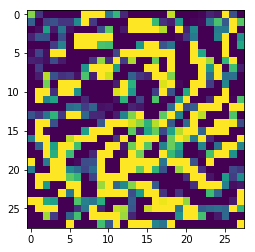

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
adv_img = generate_adversary(img,5,mnist_model,l1(0.01),'negative_categorical_crossentropy')

In [41]:
adv_img = adv_img.reshape((1, 28,28,1))
noisy_prediction = mnist_model.predict(adv_img)
print(noisy_prediction)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


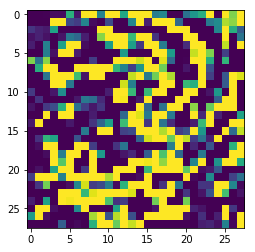

[[0.0000000e+00 0.0000000e+00 3.0031264e-25 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


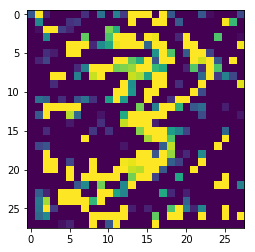

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


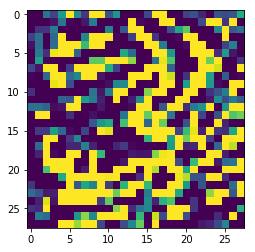

[[0.0000000e+00 0.0000000e+00 8.7804714e-32 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


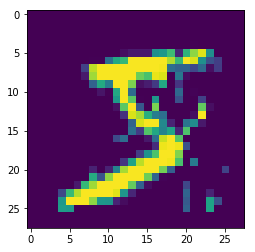

[[1.1615061e-09 1.3236287e-12 6.4607920e-12 1.3527816e-06 2.7650724e-06
  2.3982575e-04 1.3465138e-11 7.3396706e-09 4.9093123e-06 9.9975115e-01]]


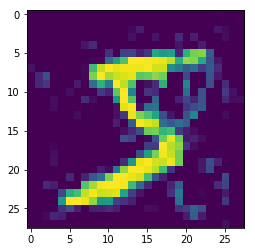

[[1.75247458e-12 1.25931245e-11 2.47431893e-12 1.90877827e-07
  2.76839091e-06 2.73096484e-05 1.15858833e-13 7.28849585e-08
  4.22598646e-07 9.99969244e-01]]


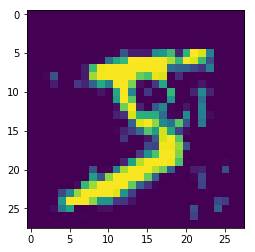

[[1.1819994e-10 5.7690717e-11 2.4771222e-12 4.7576382e-06 1.0183223e-05
  2.2209910e-04 5.8247053e-12 1.6290024e-07 4.0505056e-06 9.9975878e-01]]


In [45]:
a1 = generate_adversary(img,5,mnist_model,l1(0.01),'negative_categorical_crossentropy')
a2 = generate_adversary(img,5,mnist_model,l2(0.01),'negative_categorical_crossentropy')
a3 = generate_adversary(img,5,mnist_model,l1_l2(l1=0.01,l2=0.01),'negative_categorical_crossentropy')

a4 = generate_adversary(img,9,mnist_model,l1(0.01),'categorical_crossentropy')
a5 = generate_adversary(img,9,mnist_model,l2(0.01),'categorical_crossentropy')
a6 = generate_adversary(img,9,mnist_model,l1_l2(l1=0.01,l2=0.01),'categorical_crossentropy')

In [51]:
r6 = a6.reshape((1,28,28,1))
noisy_prediction = mnist_model.predict(r6)
print(noisy_prediction)

[[1.1819994e-10 5.7690717e-11 2.4771222e-12 4.7576382e-06 1.0183223e-05
  2.2209910e-04 5.8247053e-12 1.6290024e-07 4.0505056e-06 9.9975878e-01]]
